# Data Preprocessing

The code within this notebook is a representation of the original pre-processing steps. This notebook entails using `NLTK`'s default corpus of stopwords as well as utilizing only the `Doc2Vec` model to produce the vectorized matrices as input for the models.

## Extract data into pandas dataframe

Ensure that the `AMAZON_FASHION.json.gz` file has been downloaded and copied into this directory. See `README.md` for more information.

In [4]:
import pandas as pd
import gzip
import json

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  df = {}
  for i, d in enumerate(parse(path)):
    df[i] = d
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('../../data/raw/AMAZON_FASHION.json.gz')

In [6]:
# Remove duplicate reviews
# Any review with the same reviewText, reviewerID, overall ranking is considered a duplicate
df = df.drop_duplicates(subset=['reviewText', 'reviewerID', 'overall'])

# Keep relevant columns
df = df[['reviewText', 'summary', 'overall']]

# Drop reviews with no reviewText since we are primarily interested in analyzing review text
df = df.dropna(subset=['reviewText'])

df.head()

,reviewText,summary,overall
0,Exactly what I needed.,perfect replacements!!,5.0
1,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",2.0
2,Love these... I am going to order another pack...,My New 'Friends' !!,4.0
3,too tiny an opening,Two Stars,2.0
4,Okay,Three Stars,3.0


In [7]:
# Replace NaN values with empty strings in 'summary' column
df['summary'].fillna('', inplace=True)


In [8]:
# Check for NaN values in each column
nan_columns = df.isna().any()
print("Columns with NaN values:")
print(nan_columns)

Columns with NaN values:
reviewText    False
summary       False
overall       False
dtype: bool


## EDA

Distribution of star ratings

<Axes: >

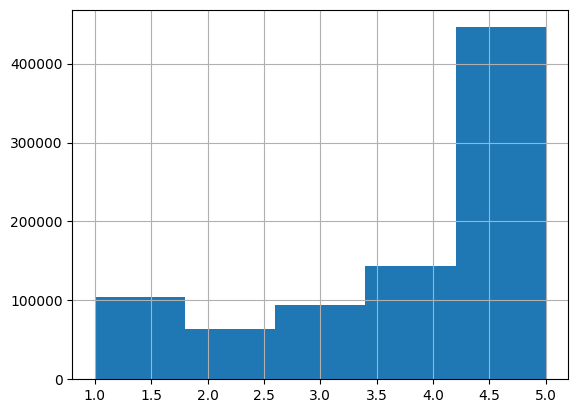

In [9]:
df['overall'].hist(bins=5)

Star ratings skew left with a clear peak for 5 stars. To avoid bias, we could consider sampling to achieve more equally distributed training data.

In [10]:
df['reviewTextLength'] = df['reviewText'].str.len()
df['reviewTextLength'].describe()

count    851740.000000
mean        147.683403
std         202.048854
min           1.000000
25%          36.000000
50%          88.000000
75%         180.000000
max       10565.000000
Name: reviewTextLength, dtype: float64

reviewTextLength
1         154
2        1739
3         594
4        7743
5        4941
         ... 
6543        1
6688        1
7398        1
9461        1
10565       1
Name: count, Length: 2582, dtype: int64


<Axes: >

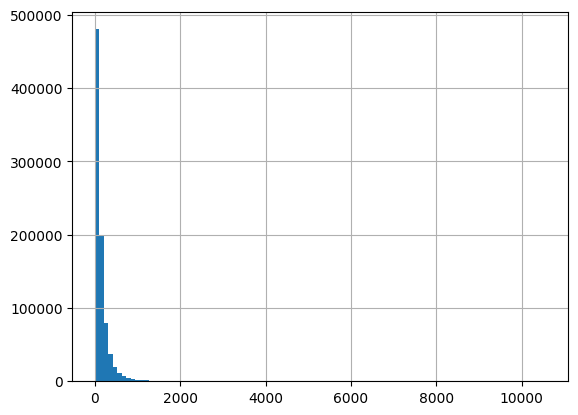

In [11]:
# look at distribution of reviewTextLength
print(df['reviewTextLength'].value_counts().sort_index())
df['reviewTextLength'].hist(bins=100)

This shows that review length skews right with many large outliers.

## Tokenization

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download necessary resources
nltk.download('punkt')
nltk.download('wordnet')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Function to tokenize, stem, and lemmatize the review text
def tokenize_stem_lemmatize_review(review, stopwords):
    tokens = nltk.word_tokenize(review)
    tokens = [t.lower() for t in tokens if t.lower() not in stopwords]
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens]
    return lemmatized_tokens

# Define stopwords
stopwords = stopwords.words('english')

# Apply tokenization, stemming, and lemmatization to each review text
df['reviewTokens'] = df.apply(lambda row: tokenize_stem_lemmatize_review(row['reviewText'], stopwords), axis=1)
df['summaryTokens'] = df.apply(lambda row: tokenize_stem_lemmatize_review(row['summary'], stopwords), axis=1)

df.head()


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kingnutmegs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kingnutmegs/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,reviewText,summary,overall,reviewTextLength,reviewTokens,summaryTokens
0,Exactly what I needed.,perfect replacements!!,5.0,22,"[exactli, need, .]","[perfect, replac, !, !]"
1,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",2.0,239,"[agre, review, ,, open, small, ., almost, bent...","[agre, review, ,, open, ...]"
2,Love these... I am going to order another pack...,My New 'Friends' !!,4.0,244,"[love, ..., go, order, anoth, pack, keep, work...","[new, 'friend, ', !, !]"
3,too tiny an opening,Two Stars,2.0,19,"[tini, open]","[two, star]"
4,Okay,Three Stars,3.0,4,[okay],"[three, star]"


In [13]:
# Check for NaN values in each column and replace them
df['reviewText'].fillna('', inplace=True)
df['summary'].fillna('',inplace=True)

In [14]:
nan_columns = df.isna().any()
print("Columns with NaN values:")
print(nan_columns)

Columns with NaN values:
reviewText          False
summary             False
overall             False
reviewTextLength    False
reviewTokens        False
summaryTokens       False
dtype: bool


In [15]:
# Save the new DataFrame as CSV
new_csv_file_path = '../../data/processed/tokenized_data.csv'

df.to_csv(new_csv_file_path)

# Confirm the CSV file has been saved
print(f"CSV file saved as '{new_csv_file_path}'")


CSV file saved as '../../data/processed/tokenized_data.csv'


In [16]:
df_new = pd.read_csv('../../data/processed/tokenized_data.csv')
nan_columns = df_new.isna().any()

# TODO: For some reason saving the NaN values even though there are none present before saving
print("Columns with NaN values:")
print(nan_columns)

Columns with NaN values:
Unnamed: 0          False
reviewText           True
summary              True
overall             False
reviewTextLength    False
reviewTokens        False
summaryTokens       False
dtype: bool


## Vectorizing Textual Features

In [21]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import pandas as pd


df['reviewText'].fillna('', inplace=True)
df['summary'].fillna('',inplace=True)

# Concatenate 'reviewTokens' and 'summaryTokens' for each row into single feature
tokenized_data = [row['reviewTokens'] + row['summaryTokens'] for _, row in df.iterrows()]

# Tag the documents
tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(tokenized_data)]

# Train the Doc2Vec model
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size, alpha=alpha, min_alpha=0.00025, min_count=1, dm=1)
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    model.alpha -= 0.0002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay

# Vectorize the textual features
vectorized_features = [model.infer_vector(doc.words) for doc in tagged_data]


In [ ]:
import numpy as np

# Convert the list to a NumPy array
vectorized_features_array = np.array(vectorized_features)

# Save the NumPy array
np.save('../../data/processed/vectorized_features_with_summary_tokens.npy', vectorized_features_array)
